# Reto: Análisis de Sentimientos

In this ___ we seek to identify whether a review for a movie is positive or negative. 

We will be using a Kaggle dataset called [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) created by Stanford University. The dataset contains 50,000 movie reviews for natural language processing or Text analytics.

We will explore the database to identify if there is a need to clean up the data; and then analyze it to become more familiar with it.

## Data Extraction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras import models, initializers
import gensim.downloader as api
from collections import Counter
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from google.colab import files,drive

drive.mount("/content/gdrive/")  
# !pwd
# !ls

%cd "/content/gdrive/Shareddrives/Aplicaciones Avanzadas"
# !ls

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/gdrive/
/content/gdrive/Shareddrives/Aplicaciones Avanzadas


Data reading and storage in a DataFrame.

In [3]:
reviews = pd.read_csv("IMDB Dataset.csv")
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Info provides a summary of the dataframe, including information about the data type of each variable. 

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


As we can see we have 2 object variables. And none of them is null. 

Describe is used to get general information about the dataset.

In [5]:
reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


As we can see there are 50000 reviews. 49,582 of them are unique, which means there are some duplicated data. The top data was a comment which it's possible to be the duplicated one. 

In [6]:
def drop_duplicates(df):
  return df.drop_duplicates()
reviews = drop_duplicates(reviews)
reviews.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


After deleting duplicates, we have 49,582 reviews left. 

It is also useful to analize the quantity of positives and negatives we have. We can use describe to get general information on the variable 'sentiment'

In [7]:
reviews.groupby(['sentiment']).describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   24698  24698  Basically there's a family where a little boy ...   
positive   24884  24884  One of the other reviewers has mentioned that ...   

                
          freq  
sentiment       
negative     1  
positive     1

Text(0, 0.5, 'Sentiment')

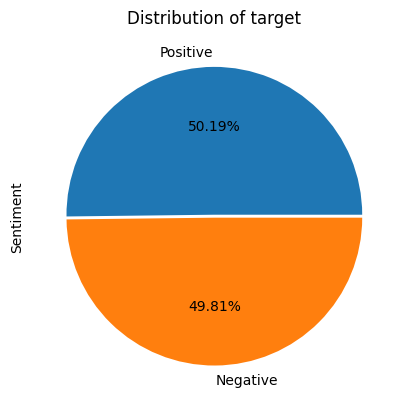

In [8]:
plt.pie(reviews['sentiment'].value_counts(),labels=['Positive','Negative'],autopct='%.2f%%',explode=[0.01,0.01]);
plt.title('Distribution of target')
plt.ylabel('Sentiment')

As we can see the data is balanced, we have almost the same amount of positive and negative reviews. 

We can also delete duplicates in case they exist. 

### Review Length

It is useful to analyze the size of the reviews to get more information about them. Also in some previous articles they mention that the size of the reviews for model input had a large effect on the effectiveness of the model. 

To analyze the length we created a new variable called *review_size* which contains the number of words of the review. 

In [9]:
def count_words(text):
    words = text.split()
    return len(words)

In [10]:
reviews['review_size'] = reviews['review'].apply(lambda x: count_words(x))

In [11]:
reviews.head()

,review,sentiment,review_size
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


In [12]:
reviews.describe()

,review_size
count,49582.000000
mean,231.350167
std,171.542020
min,4.000000
25%,126.000000
50%,173.000000
75%,281.000000
max,2470.000000


In [13]:
reviews.groupby(['sentiment']).describe()

review_size                                                     \
                count        mean         std   min    25%    50%    75%   
sentiment                                                                  
negative      24698.0  229.596607  165.103430   4.0  128.0  174.0  278.0   
positive      24884.0  233.090620  177.688169  10.0  125.0  172.0  284.0   

                   
              max  
sentiment          
negative   1522.0  
positive   2470.0

<Axes: xlabel='sentiment'>

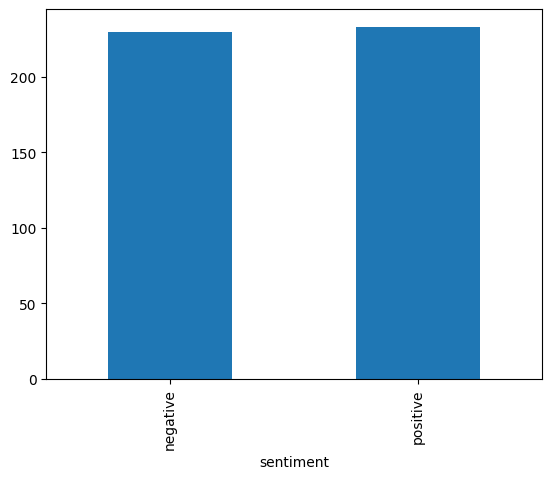

In [14]:
reviews.groupby('sentiment')['review_size'].mean().plot(kind='bar')

As we can see the size is very similar for negative and positive comments, they have a similar average. The biggest difference is that the longest negative review is 1,522 words long, while the longest positive has 2,470 words. 

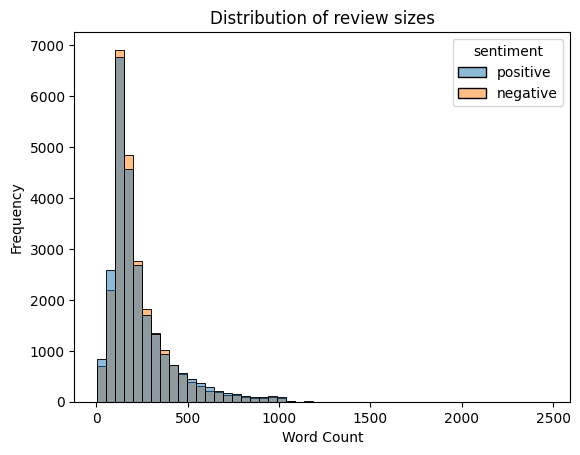

In [15]:
def plot_dist(reviews):
  # Generar histograma
  sns.histplot(data=reviews, x='review_size', bins = 50, hue='sentiment')

  # Etiquetas y título
  plt.xlabel('Word Count')
  plt.ylabel('Frequency')
  plt.title('Distribution of review sizes')

  # Mostrar el histograma
  plt.show()

plot_dist(reviews)
reviews = reviews.drop('review_size', axis=1)

The distribution of the number of words is skewed to the right. The average number of words per review is approximately 230. As can be seen in the histogram above, the distribution of the number of words is very similar for positive and negative comments, so the data is balanced.

### Stop Words

It is of great importance to analyze which are the most repeated words in positive and negative comments. To see if there are words that stand out and indicate whether a comment is positive or negative. 

It was important to eliminate stopwords, since they do not provide valuable information and would be the most frequently used words. This was done using the nltk tokenize library.

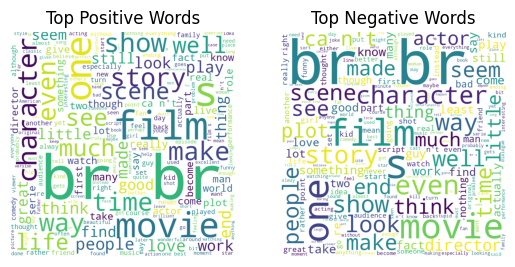

In [16]:
positive_data = reviews[reviews['sentiment']=='positive']
positive_data = positive_data['review']
negative_data = reviews[reviews['sentiment']=='negative']
negative_data = negative_data['review']


def remove_stopwords(text):
  stopwords_list = set(stopwords.words('english'))
  words = word_tokenize(text)
  words_without_stopwords = [word for word in words if word.lower() not in stopwords_list]
  words_without_stopwords = ' '.join(words_without_stopwords)
  return words_without_stopwords

def show_wordcloud(data, title):
  wordcloud = WordCloud(width=800, height=800, background_color='white').generate(data)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(title)


top_words_positive = ""
for line in positive_data:
 top_words_positive +=  remove_stopwords(line) + " "

top_words_negative = ""
for line in negative_data:
 top_words_negative +=  remove_stopwords(line) + " "


plt.subplot(1,2,1)
show_wordcloud(top_words_positive, 'Top Positive Words')

plt.subplot(1,2,2)
show_wordcloud(top_words_negative, 'Top Negative Words')
plt.show()


As we can see some of the words contained are HTML tags, which will need to remove.

## Data Preprocessing


### Lower Case

Convert all uppercase to lowercase since Machine Learning algorithms do not differentiate between the two of them and it improves training efficiency.


In [17]:
def lowercase(df):
  df['review'] = df['review'].apply(lambda x : x.lower())

lowercase(reviews)
reviews.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove noise

Remove irrelevant information contained in the reviews: HTML tags and any character that is not a word

In [18]:
def remove_noise(text):
  # Remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # Remove any caracter that is not a word character (letter, digit or underscore) or whitespace
  text = re.sub(r'[^\w\s]', '', text)
  return text

reviews['review'] = reviews['review'].apply(remove_noise)
reviews.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


### Remove Stopwords
Remove words that are not useful for performing sentiment analysis like: of, the, has, etc.


In [19]:
reviews['review'] = reviews['review'].apply(remove_stopwords)
reviews.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


### Remove double spaces

In [20]:
def remove_double_spaces(text):
  text = re.sub(r'\s+', ' ', text)
  return text

reviews['review'] = reviews['review'].apply(remove_double_spaces)
reviews.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


### Change sentiment variable to Dummy

The column sentiment is made dummy, so the value of the sentiment is 1 if the review is positive or 0 if the review is negative. 
Dummy variables represent categorical variables in an way the can be used by machine learning algorithms. 

In [21]:
def change_sentiment(df):
  return df['sentiment'].replace(['positive', 'negative'],[1.0, 0.0], inplace=True)

change_sentiment(reviews)
reviews.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1.0
1,wonderful little production filming technique ...,1.0
2,thought wonderful way spend time hot summer we...,1.0
3,basically theres family little boy jake thinks...,0.0
4,petter matteis love time money visually stunni...,1.0


In [22]:
reviews['review_size'] = reviews['review'].apply(lambda x: count_words(x))
reviews[['review_size']].describe()

,review_size
count,49582.000000
mean,119.876850
std,90.066502
min,3.000000
25%,64.000000
50%,89.000000
75%,146.000000
max,1429.000000


After the preprocessing, the number of words in each review decreases. As que can see the new mean of review_size is 120 words. 

<Axes: xlabel='sentiment'>

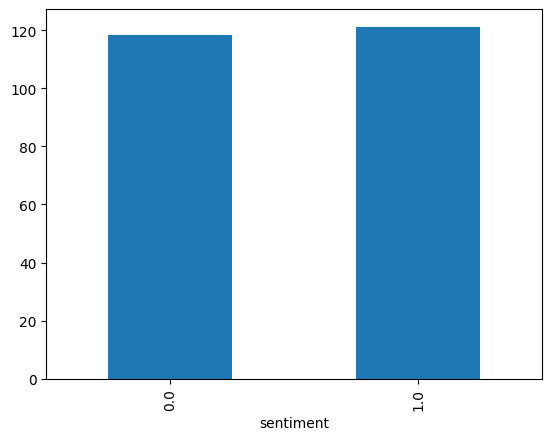

In [23]:
reviews.groupby('sentiment')['review_size'].mean().plot(kind='bar')

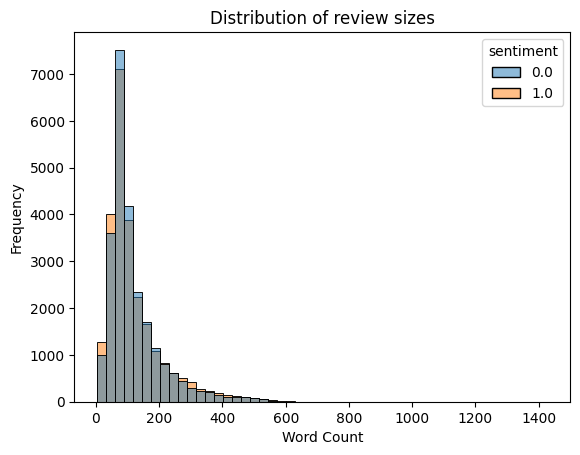

In [24]:
plot_dist(reviews)

## Embedding

Machine learning algorithms can't process textual data, so it's necessary to transform text into a numerical representation. Embedding represents the words as vectors. 

Embedding allows the model to learn and understand the underlying sentiment conveyed by words in a text. Words with similar sentiments or meanings tend to have similar vector representations, enabling the model to generalize and make accurate predictions. 

### Tokenization

Tokenization, each word in a text is assigned a unique numerical identifier, which allows the text to be processed by machine learning models.

This function will receive a different length to consider for the reviews by truncating them at the end if they exceed the maximum length allowed or completing them with empty spaces if the review is shorter.

In [25]:
def tokenizate(reviews, max_review_len, max_words_total):
  X_embedded = reviews['review'].to_numpy()
  Y = reviews['sentiment'].to_numpy()

  tokenizer = Tokenizer(num_words=max_words_total)
  tokenizer.fit_on_texts(X_embedded)
  sequences = tokenizer.texts_to_sequences(X_embedded)
  word_index = tokenizer.word_index
  X_embedded = pad_sequences(sequences, maxlen=max_review_len, padding='pre', truncating='pre')

  print(f'Found {len(word_index)} unique tokens.')
  print(f'Shape of data tensor: {X_embedded.shape}')
  return word_index, X_embedded

### Pre-trained Word2vec embedding

Word2Vec takes these tokenized words and learns to generate word embeddings by predicting the context of each word in a given window of surrounding words.

In [26]:
word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [27]:
# Prepare the embedding matrix
def embedding_mat(word_index, max_words_total):
  embedding_dim = word2vec_model.vector_size
  embedding_matrix = np.zeros((max_words_total, embedding_dim))

  for word, i in word_index.items():
      if i < max_words_total:
          if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
  print(f'Shape of embedding matrix: {embedding_matrix.shape}')
  return embedding_matrix

### Train Test Dataset Split

In [28]:
def split_data(X, Y):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 15)
  print("Train sizes", X_train.shape,Y_train.shape)
  print("Test sizes", X_test.shape,Y_test.shape)
  return X_train, X_test, Y_train, Y_test

### Function to plot loss and accuracy

In [29]:
def plot_history(history):
  # Plot Loss for train dataset and validation split
  plt.subplot(1, 2, 1)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")
  plt.plot(history.history["loss"], label='Train Loss')
  plt.plot(history.history["val_loss"], label='Validation Loss')
  plt.title("Loss Function")
  plt.legend()

  # Plot accuracy for train dataset and validation split
  plt.subplot(1, 2, 2)
  plt.xlabel("Epoch")
  plt.ylabel("Binary Accuracy")
  plt.plot(history.history["accuracy"], color = "green", label='Train Accuracy')
  plt.plot(history.history["val_accuracy"], label='Validation Accuracy')
  plt.title("Accuracy")
  plt.legend()
  plt.show()

In [30]:
def evaluate_model(model, X_test, Y_test):
  print("---MODEL EVALUATION---")
  # Perform predictions on test data
  y_pred = model.predict(X_test)
  # y_pred = np.round(y_pred).flatten()
  y_pred = np.rint(y_pred)
  cm = confusion_matrix(Y_test, y_pred)
  accuracy = accuracy_score(Y_test, y_pred)
  # Calculate precision
  precision = precision_score(Y_test, y_pred)
  # Calculate recall
  recall = recall_score(Y_test, y_pred)
  # Calculate F1 score
  f1 = f1_score(Y_test, y_pred)

  # Print the metrics
  print("Confusion Matrix:")
  print(cm)
  metrics = {'Test accuracy' : accuracy, 'Precission' : precision, 'Recall' : recall, 'F1 Score' : f1}
  metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Metrics'])
  print(metrics_df)

## Train Models

Set constants to use for all the models.

In [31]:
# Represents 10% of all the words used in the reviews after preprocessing
MAX_WORDS_TOTAL = 22175
EMBEDDING_DIM = word2vec_model.vector_size

Define length of padding sequence for all reviews and tokenize them. Create embedding matrix using word2vec for every word in the tokenization dictionary used.

In [32]:
review_len_50 = 89
review_len_mean = 120
review_len_75 = 146
word_index, X_embedded_50 = tokenizate(reviews, review_len_50, MAX_WORDS_TOTAL)
word_index, X_embedded_mean = tokenizate(reviews, review_len_mean, MAX_WORDS_TOTAL)
word_index, X_embedded_75 = tokenizate(reviews, review_len_75, MAX_WORDS_TOTAL)
embedding_matrix = embedding_mat(word_index, MAX_WORDS_TOTAL)

Found 221751 unique tokens.
Shape of data tensor: (49582, 89)
Found 221751 unique tokens.
Shape of data tensor: (49582, 120)
Found 221751 unique tokens.
Shape of data tensor: (49582, 146)
Shape of embedding matrix: (22175, 300)


Slit tokenized and padded reviews in train and test.

In [33]:
Y = reviews['sentiment'].to_numpy()
X_train_50, X_test_50, Y_train_50, Y_test_50 = split_data(X_embedded_50, Y)
X_train_mean, X_test_mean, Y_train_mean, Y_test_mean = split_data(X_embedded_mean, Y)
X_train_75, X_test_75, Y_train_75, Y_test_75 = split_data(X_embedded_75, Y)

Train sizes (39665, 89) (39665,)
Test sizes (9917, 89) (9917,)
Train sizes (39665, 120) (39665,)
Test sizes (9917, 120) (9917,)
Train sizes (39665, 146) (39665,)
Test sizes (9917, 146) (9917,)


### 1. Deep Neural Network

In [54]:
def DNN(max_words_total, max_review_len, X_train, X_test, Y_train, Y_test, embedding_matrix=[], epochs=6):
  model = Sequential()
  if len(embedding_matrix) > 0:
    model.add(Embedding(max_words_total, embedding_matrix.shape[1], input_length=max_review_len,
                weights=[embedding_matrix], trainable=False))
  else:
    model.add(Embedding(max_words_total, EMBEDDING_DIM, input_length=max_review_len))
  model.add(Flatten())
  model.add(Dense(8, activation='relu', kernel_initializer=initializers.HeUniform()))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  print(model.summary())
  model.compile(
      optimizer='rmsprop',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  history = model.fit(
      X_train,
      Y_train,
      epochs=epochs,
      verbose=True,
      batch_size=512,
      validation_split=0.15
  )
  return model, history

#### 1.1 Deep Neural Network for 89 word padded reviews.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 89, 300)           6652500   
                                                                 
 flatten_5 (Flatten)         (None, 26700)             0         
                                                                 
 dense_16 (Dense)            (None, 8)                 213608    
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,866,117
Trainable params: 6,866,117
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
66/66 [======================

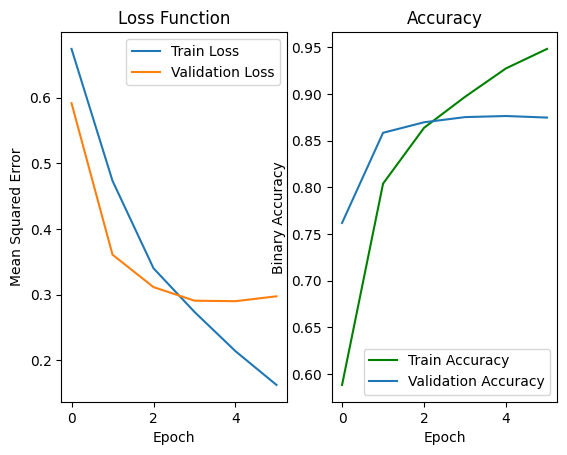

---MODEL EVALUATION---
310/310 [==============================] - 1s 3ms/step
Confusion Matrix:
[[4205  713]
 [ 559 4440]]
                Metrics
Test accuracy  0.871735
Precission     0.861634
Recall         0.888178
F1 Score       0.874704


In [55]:
DNN_50, h_DNN_50 = DNN(MAX_WORDS_TOTAL, review_len_50, X_train_50, X_test_50, Y_train_50, Y_test_50, epochs=6)
plot_history(h_DNN_50)
evaluate_model(DNN_50, X_test_50, Y_test_50)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 89, 300)           6652500   
                                                                 
 flatten_4 (Flatten)         (None, 26700)             0         
                                                                 
 dense_20 (Dense)            (None, 8)                 213608    
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,866,117
Trainable params: 213,617
Non-trainable params: 6,652,500
_________________________________________________________________
None
Epoch 1/5
66/66 [===============

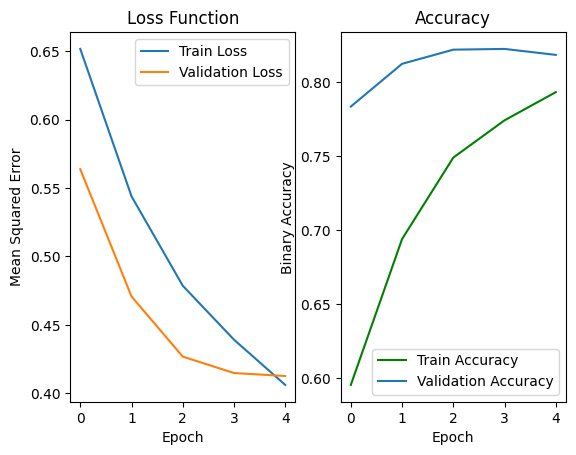

---MODEL EVALUATION---
310/310 [==============================] - 1s 2ms/step
Confusion Matrix:
[[3697 1221]
 [ 619 4380]]
                Metrics
Test accuracy  0.814460
Precission     0.782003
Recall         0.876175
F1 Score       0.826415


In [52]:
DNN_50_w2v, h_DNN_50_w2v = DNN(MAX_WORDS_TOTAL, review_len_50, X_train_50, X_test_50, Y_train_50, Y_test_50, embedding_matrix=embedding_matrix, epochs=5)
plot_history(h_DNN_50_w2v)
evaluate_model(DNN_50_w2v, X_test_50, Y_test_50)

#### 1.2 Deep Neural Network for 120 word padded reviews.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 300)          6652500   
                                                                 
 flatten_6 (Flatten)         (None, 36000)             0         
                                                                 
 dense_18 (Dense)            (None, 8)                 288008    
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,940,517
Trainable params: 6,940,517
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
66/66 [======================

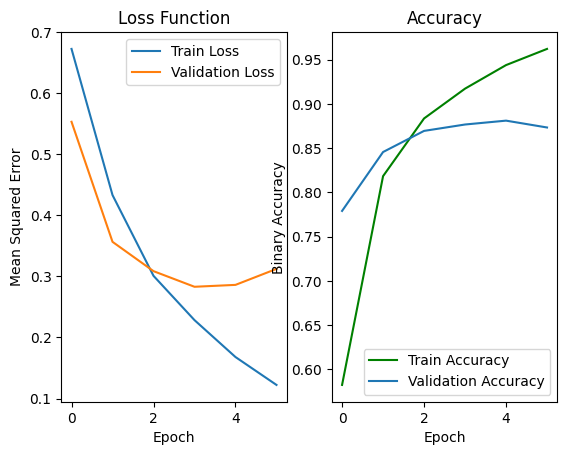

---MODEL EVALUATION---
310/310 [==============================] - 1s 4ms/step
Confusion Matrix:
[[4431  487]
 [ 780 4219]]
                Metrics
Test accuracy  0.872240
Precission     0.896515
Recall         0.843969
F1 Score       0.869449


In [56]:
DNN_mean, h_DNN_mean = DNN(MAX_WORDS_TOTAL, review_len_mean, X_train_mean, X_test_mean, Y_train_mean, Y_test_mean, epochs=6)
plot_history(h_DNN_mean)
evaluate_model(DNN_mean, X_test_mean, Y_test_mean)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 120, 300)          6652500   
                                                                 
 flatten_9 (Flatten)         (None, 36000)             0         
                                                                 
 dense_30 (Dense)            (None, 8)                 288008    
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 6,940,517
Trainable params: 288,017
Non-trainable params: 6,652,500
_________________________________________________________________
None
Epoch 1/7
66/66 [===============

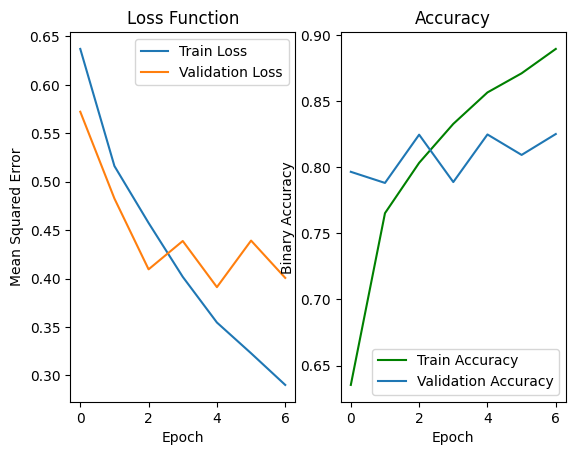

---MODEL EVALUATION---
310/310 [==============================] - 1s 2ms/step
Confusion Matrix:
[[4129  789]
 [ 970 4029]]
                Metrics
Test accuracy  0.822628
Precission     0.836239
Recall         0.805961
F1 Score       0.820821


In [59]:
DNN_mean_w2v, h_DNN_mean_w2v = DNN(MAX_WORDS_TOTAL, review_len_mean, X_train_mean, X_test_mean, Y_train_mean, Y_test_mean, embedding_matrix=embedding_matrix, epochs=7)
plot_history(h_DNN_mean_w2v)
evaluate_model(DNN_mean_w2v, X_test_mean, Y_test_mean)

#### 1.3 Deep Neural Network for 146 word padded reviews.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 146, 300)          6652500   
                                                                 
 flatten_7 (Flatten)         (None, 43800)             0         
                                                                 
 dense_20 (Dense)            (None, 8)                 350408    
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 7,002,917
Trainable params: 7,002,917
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
66/66 [=====================

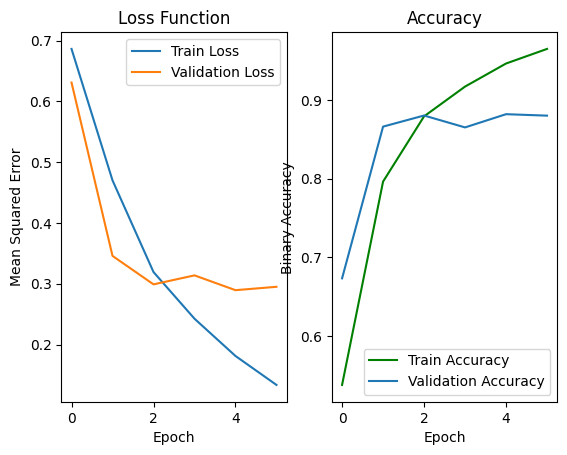

---MODEL EVALUATION---
310/310 [==============================] - 2s 5ms/step
Confusion Matrix:
[[4345  573]
 [ 643 4356]]
                Metrics
Test accuracy  0.877382
Precission     0.883749
Recall         0.871374
F1 Score       0.877518


In [57]:
DNN_75, h_DNN_75 = DNN(MAX_WORDS_TOTAL, review_len_75, X_train_75, X_test_75, Y_train_75, Y_test_75, epochs=6)
plot_history(h_DNN_75)
evaluate_model(DNN_75, X_test_75, Y_test_75)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 146, 300)          6652500   
                                                                 
 flatten_12 (Flatten)        (None, 43800)             0         
                                                                 
 dense_36 (Dense)            (None, 8)                 350408    
                                                                 
 dropout_18 (Dropout)        (None, 8)                 0         
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 7,002,917
Trainable params: 350,417
Non-trainable params: 6,652,500
_________________________________________________________________
None
Epoch 1/6
66/66 [===============

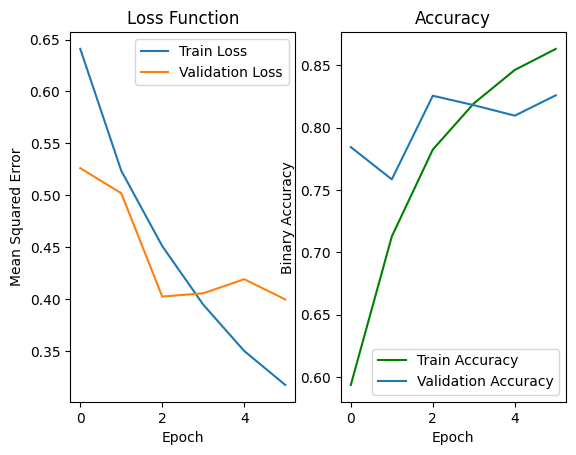

---MODEL EVALUATION---
310/310 [==============================] - 1s 2ms/step
Confusion Matrix:
[[3876 1042]
 [ 710 4289]]
                Metrics
Test accuracy  0.823334
Precission     0.804539
Recall         0.857972
F1 Score       0.830397


In [64]:
DNN_75_w2v, h_DNN_75_w2v = DNN(MAX_WORDS_TOTAL, review_len_75, X_train_75, X_test_75, Y_train_75, Y_test_75, embedding_matrix=embedding_matrix, epochs=6)
plot_history(h_DNN_75_w2v)
evaluate_model(DNN_75_w2v, X_test_75, Y_test_75)

### 2. LSTM Neural Network

In [60]:
def LSTM_NN(max_words_total, max_review_len, X_train, X_test, Y_train, Y_test, embedding_matrix=[], epochs=6):
  model = Sequential()
  if len(embedding_matrix) > 0:
    model.add(Embedding(max_words_total, embedding_matrix.shape[1], input_length=max_review_len,
                weights=[embedding_matrix], trainable=False))
  else:
    model.add(Embedding(max_words_total, EMBEDDING_DIM, input_length=max_review_len))
  model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(64, activation='relu', kernel_initializer=initializers.HeUniform()))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))
  print(model.summary())
  model.compile(
      optimizer='rmsprop',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  history = model.fit(
      X_train,
      Y_train,
      epochs=epochs,
      verbose=True,
      batch_size=512,
      validation_split=0.15
  )
  return model, history

#### 2.1 LSTM Neural Network for 89 word padded reviews.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 89, 300)           6652500   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,880,469
Trainable params: 6,880,469
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
66/66 [========================

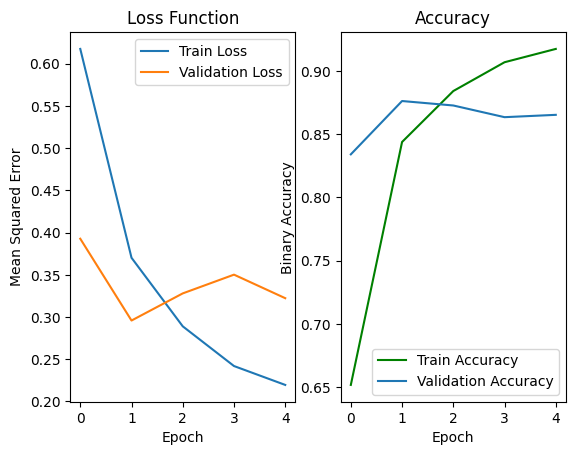

---MODEL EVALUATION---
310/310 [==============================] - 12s 37ms/step
Confusion Matrix:
[[4564  354]
 [1060 3939]]
                Metrics
Test accuracy  0.857417
Precission     0.917540
Recall         0.787958
F1 Score       0.847826


In [35]:
LSTM_NN_50, h_LSTM_NN_50 = LSTM_NN(MAX_WORDS_TOTAL, review_len_50, X_train_50, X_test_50, Y_train_50, Y_test_50, epochs=5)
plot_history(h_LSTM_NN_50)
evaluate_model(LSTM_NN_50, X_test_50, Y_test_50)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 89, 300)           6652500   
                                                                 
 lstm_3 (LSTM)               (None, 128)               219648    
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_39 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,880,469
Trainable params: 227,969
Non-trainable params: 6,652,500
_________________________________________________________________
None
Epoch 1/5
66/66 [===============

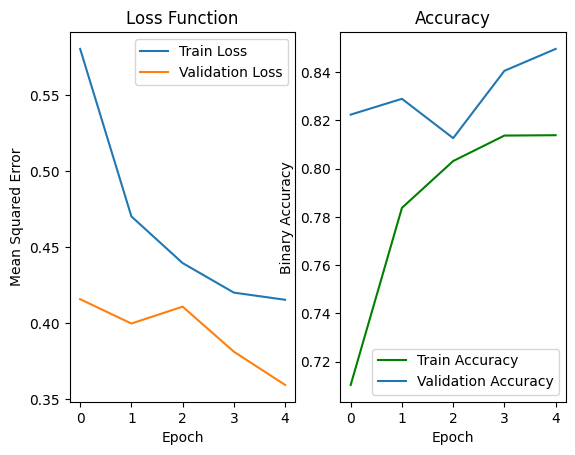

---MODEL EVALUATION---
310/310 [==============================] - 11s 34ms/step
Confusion Matrix:
[[4330  588]
 [1015 3984]]
                Metrics
Test accuracy  0.838358
Precission     0.871391
Recall         0.796959
F1 Score       0.832515


In [65]:
LSTM_NN_50_w2v, h_LSTM_NN_50_w2v = LSTM_NN(MAX_WORDS_TOTAL, review_len_50, X_train_50, X_test_50, Y_train_50, Y_test_50, embedding_matrix=embedding_matrix, epochs=5)
plot_history(h_LSTM_NN_50_w2v)
evaluate_model(LSTM_NN_50_w2v, X_test_50, Y_test_50)

#### 2.2 LSTM Neural Network for 120 word padded reviews.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 300)          6652500   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,880,469
Trainable params: 6,880,469
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
66/66 [======================

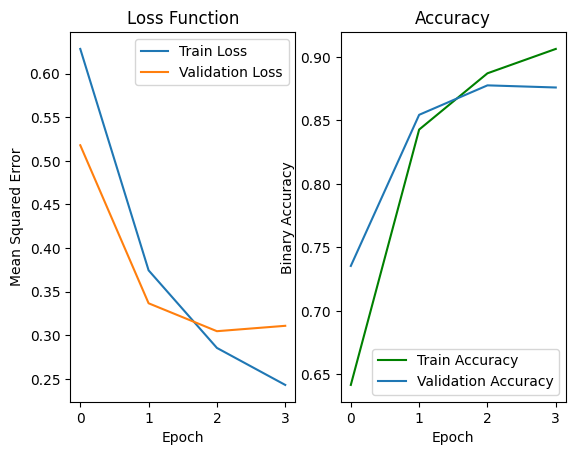

---MODEL EVALUATION---
310/310 [==============================] - 14s 43ms/step
Confusion Matrix:
[[4593  325]
 [ 966 4033]]
                Metrics
Test accuracy  0.869820
Precission     0.925425
Recall         0.806761
F1 Score       0.862028


In [36]:
LSTM_NN_mean, h_LSTM_NN_mean = LSTM_NN(MAX_WORDS_TOTAL, review_len_mean, X_train_mean, X_test_mean, Y_train_mean, Y_test_mean, epochs=4)
plot_history(h_LSTM_NN_mean)
evaluate_model(LSTM_NN_mean, X_test_mean, Y_test_mean)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 120, 300)          6652500   
                                                                 
 lstm_4 (LSTM)               (None, 128)               219648    
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,880,469
Trainable params: 227,969
Non-trainable params: 6,652,500
_________________________________________________________________
None
Epoch 1/4
66/66 [===============

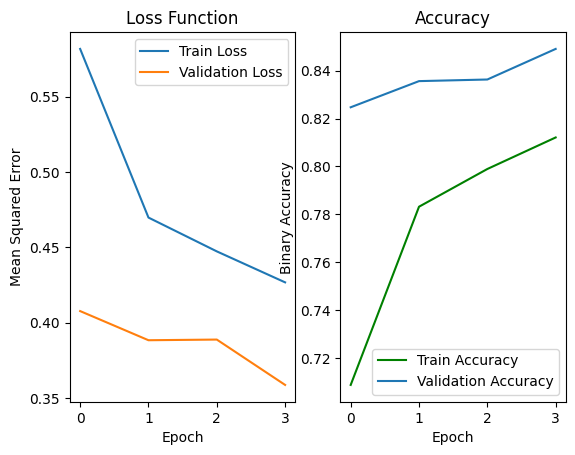

---MODEL EVALUATION---
310/310 [==============================] - 14s 46ms/step
Confusion Matrix:
[[4248  670]
 [ 870 4129]]
                Metrics
Test accuracy  0.844711
Precission     0.860388
Recall         0.825965
F1 Score       0.842825


In [66]:
LSTM_NN_mean_w2v, h_LSTM_NN_mean_w2v = LSTM_NN(MAX_WORDS_TOTAL, review_len_mean, X_train_mean, X_test_mean, Y_train_mean, Y_test_mean, embedding_matrix=embedding_matrix, epochs=4)
plot_history(h_LSTM_NN_mean_w2v)
evaluate_model(LSTM_NN_mean_w2v, X_test_mean, Y_test_mean)

#### 2.3 LSTM Neural for 146 word padded reviews.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 146, 300)          6652500   
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,880,469
Trainable params: 6,880,469
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
66/66 [======================

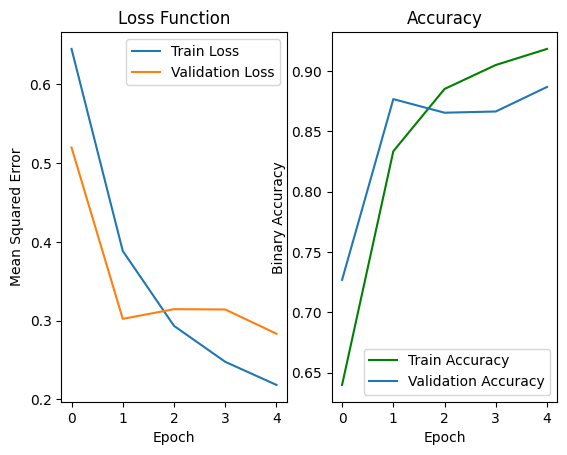

---MODEL EVALUATION---
310/310 [==============================] - 17s 54ms/step
Confusion Matrix:
[[4461  457]
 [ 725 4274]]
                Metrics
Test accuracy  0.880811
Precission     0.903403
Recall         0.854971
F1 Score       0.878520


In [37]:
LSTM_NN_75, h_LSTM_NN_75 = LSTM_NN(MAX_WORDS_TOTAL, review_len_75, X_train_75, X_test_75, Y_train_75, Y_test_75, epochs=5)
plot_history(h_LSTM_NN_75)
evaluate_model(LSTM_NN_75, X_test_75, Y_test_75)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 146, 300)          6652500   
                                                                 
 lstm_5 (LSTM)               (None, 128)               219648    
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,880,469
Trainable params: 227,969
Non-trainable params: 6,652,500
_________________________________________________________________
None
Epoch 1/5
66/66 [===============

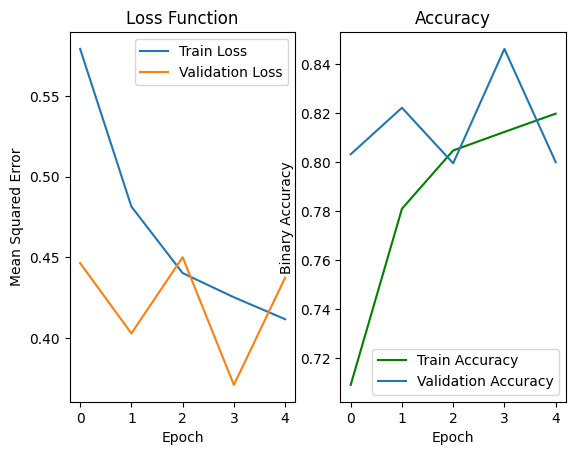

---MODEL EVALUATION---
310/310 [==============================] - 16s 53ms/step
Confusion Matrix:
[[3134 1784]
 [ 190 4809]]
                Metrics
Test accuracy  0.800948
Precission     0.729410
Recall         0.961992
F1 Score       0.829710


In [67]:
LSTM_NN_75_w2v, h_LSTM_NN_75_w2v = LSTM_NN(MAX_WORDS_TOTAL, review_len_75, X_train_75, X_test_75, Y_train_75, Y_test_75, embedding_matrix=embedding_matrix, epochs=5)
plot_history(h_LSTM_NN_75_w2v)
evaluate_model(LSTM_NN_75_w2v, X_test_75, Y_test_75)

### 3. Convolutional Neural Network

In [61]:
def CNN(max_words_total, max_review_len, X_train, X_test, Y_train, Y_test, embedding_matrix=[], epochs=6):
  model = Sequential()
  if len(embedding_matrix) > 0:
    model.add(Embedding(max_words_total, embedding_matrix.shape[1], input_length=max_review_len,
                weights=[embedding_matrix], trainable=False))
  else:
    model.add(Embedding(max_words_total, EMBEDDING_DIM, input_length=max_review_len))
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  print(model.summary())
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )
  history = model.fit(
      X_train,
      Y_train,
      epochs=epochs,
      verbose=True,
      batch_size=512,
      validation_split=0.15
  )
  return model, history

#### 3.1 Convolutional Neural Network for 89 word padded reviews.

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 89, 300)           6652500   
                                                                 
 conv1d_12 (Conv1D)          (None, 87, 128)           115328    
                                                                 
 conv1d_13 (Conv1D)          (None, 85, 64)            24640     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_50 (Dense)            (None, 50)                3250      
                                                                 
 dropout_25 (Dropout)        (None, 50)                0         
                                                     

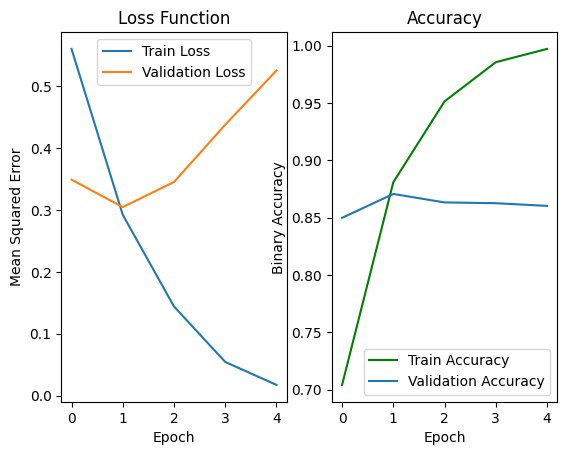

---MODEL EVALUATION---
310/310 [==============================] - 4s 12ms/step
Confusion Matrix:
[[4218  700]
 [ 686 4313]]
                Metrics
Test accuracy  0.860240
Precission     0.860363
Recall         0.862773
F1 Score       0.861566


In [71]:
CNN_50, h_CNN_50 = CNN(MAX_WORDS_TOTAL, review_len_50, X_train_50, X_test_50, Y_train_50, Y_test_50, epochs=5)
plot_history(h_CNN_50)
evaluate_model(CNN_50, X_test_50, Y_test_50)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 89, 300)           6652500   
                                                                 
 conv1d_10 (Conv1D)          (None, 87, 128)           115328    
                                                                 
 conv1d_11 (Conv1D)          (None, 85, 64)            24640     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_48 (Dense)            (None, 50)                3250      
                                                                 
 dropout_24 (Dropout)        (None, 50)                0         
                                                     

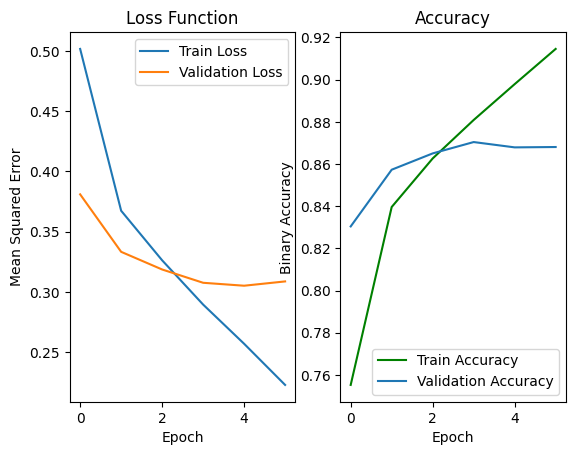

---MODEL EVALUATION---
310/310 [==============================] - 4s 12ms/step
Confusion Matrix:
[[4400  518]
 [ 804 4195]]
                Metrics
Test accuracy  0.866694
Precission     0.890091
Recall         0.839168
F1 Score       0.863880


In [70]:
CNN_50_w2v, h_CNN_50_w2v = CNN(MAX_WORDS_TOTAL, review_len_50, X_train_50, X_test_50, Y_train_50, Y_test_50, embedding_matrix=embedding_matrix, epochs=6)
plot_history(h_CNN_50_w2v)
evaluate_model(CNN_50_w2v, X_test_50, Y_test_50)

#### 3.2 Convolutional Neural Network for 120 word padded reviews.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 300)          6652500   
                                                                 
 conv1d_2 (Conv1D)           (None, 118, 128)          115328    
                                                                 
 conv1d_3 (Conv1D)           (None, 116, 64)           24640     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 50)                3250      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                      

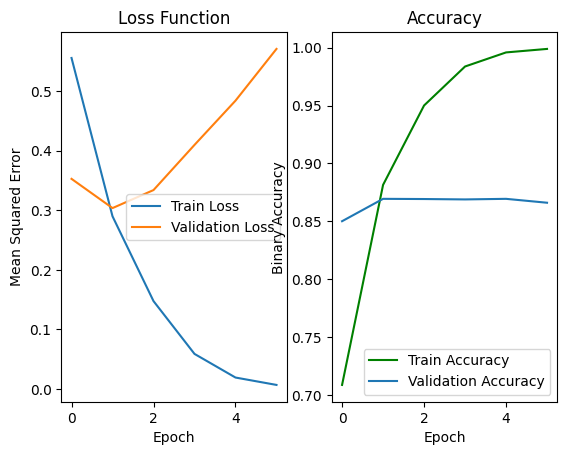

---MODEL EVALUATION---
310/310 [==============================] - 5s 16ms/step
Confusion Matrix:
[[4249  669]
 [ 686 4313]]
                Metrics
Test accuracy  0.863366
Precission     0.865717
Recall         0.862773
F1 Score       0.864242


In [40]:
CNN_mean, h_CNN_mean = CNN(MAX_WORDS_TOTAL, review_len_mean, X_train_mean, X_test_mean, Y_train_mean, Y_test_mean, epochs=6)
plot_history(h_CNN_mean)
evaluate_model(CNN_mean, X_test_mean, Y_test_mean)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 120, 300)          6652500   
                                                                 
 conv1d_8 (Conv1D)           (None, 118, 128)          115328    
                                                                 
 conv1d_9 (Conv1D)           (None, 116, 64)           24640     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_46 (Dense)            (None, 50)                3250      
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                     

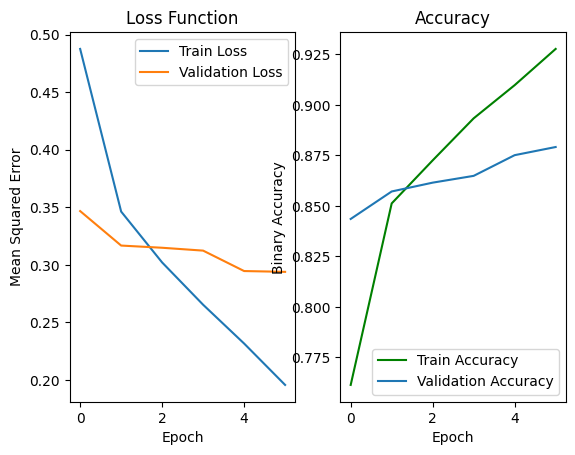

---MODEL EVALUATION---
310/310 [==============================] - 6s 18ms/step
Confusion Matrix:
[[4229  689]
 [ 557 4442]]
                Metrics
Test accuracy  0.874357
Precission     0.865718
Recall         0.888578
F1 Score       0.876999


In [69]:
CNN_mean_w2v, h_CNN_mean_w2v = CNN(MAX_WORDS_TOTAL, review_len_mean, X_train_mean, X_test_mean, Y_train_mean, Y_test_mean, embedding_matrix=embedding_matrix, epochs=6)
plot_history(h_CNN_mean_w2v)
evaluate_model(CNN_mean_w2v, X_test_mean, Y_test_mean)

#### 3.3 Convolutional Neural for 146 word padded reviews.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 146, 300)          6652500   
                                                                 
 conv1d_4 (Conv1D)           (None, 144, 128)          115328    
                                                                 
 conv1d_5 (Conv1D)           (None, 142, 64)           24640     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 50)                3250      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                      

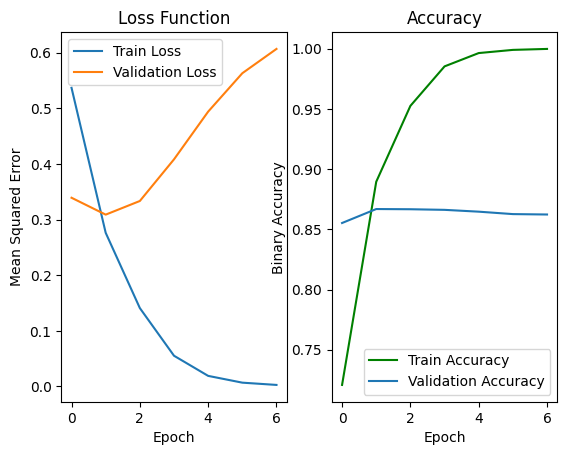

---MODEL EVALUATION---
310/310 [==============================] - 7s 22ms/step
Confusion Matrix:
[[4229  689]
 [ 649 4350]]
                Metrics
Test accuracy  0.865080
Precission     0.863267
Recall         0.870174
F1 Score       0.866707


In [41]:
CNN_75, h_CNN_75 = CNN(MAX_WORDS_TOTAL, review_len_75, X_train_75, X_test_75, Y_train_75, Y_test_75, epochs=7)
plot_history(h_CNN_75)
evaluate_model(CNN_75, X_test_75, Y_test_75)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 146, 300)          6652500   
                                                                 
 conv1d_6 (Conv1D)           (None, 144, 128)          115328    
                                                                 
 conv1d_7 (Conv1D)           (None, 142, 64)           24640     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_44 (Dense)            (None, 50)                3250      
                                                                 
 dropout_22 (Dropout)        (None, 50)                0         
                                                     

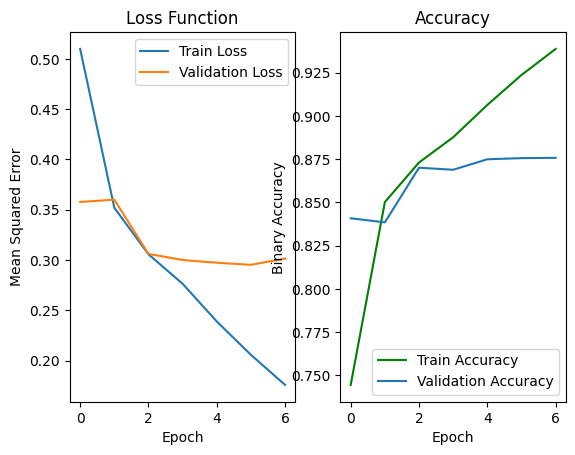

---MODEL EVALUATION---
310/310 [==============================] - 7s 22ms/step
Confusion Matrix:
[[4380  538]
 [ 688 4311]]
                Metrics
Test accuracy  0.876374
Precission     0.889049
Recall         0.862372
F1 Score       0.875508


In [68]:
CNN_75_w2v, h_CNN_75_w2v = CNN(MAX_WORDS_TOTAL, review_len_75, X_train_75, X_test_75, Y_train_75, Y_test_75, embedding_matrix=embedding_matrix, epochs=7)
plot_history(h_CNN_75_w2v)
evaluate_model(CNN_75_w2v, X_test_75, Y_test_75)